# This notebook is built to fit the One-Dimension Diffusion-Advection-Reaction model parameters to experimental data

### imports

In [105]:
import numpy as np
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-whitegrid')
from sklearn import linear_model
plt.rcParams["figure.figsize"] = (16,8)
import math
from math import sqrt
from math import e as exp
import seaborn as sns
import statsmodels.api as sm
import random
from scipy import optimize
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
import numba
from numba.experimental import jitclass
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az

### model paramenters

In [106]:
B = .10       ### biomass in Kg
D = 1e-3      ### turbid diffusion coeficient
λ =  2e-3   ### degradation rate
u = 1e7/60    ### production rate
V = 0.03      ### river velocity
BV = 1/3      ### boat velocity

T = 10*20     ### sampling time
pf = 5/1000   ### pump flow
H = 50        ### river cross section area

In [107]:
def _solved_river_abv(x):
    return  -(pf/(BV*H)) *(2*B*u*D) /( 4*D*λ - V*sqrt(V**2 + 4*D * λ)+ V**2)* exp**( (V - sqrt(V**2 + 4*D*λ))/ (2*D) * x )

def _solved_river_bl(x):
    return  (pf/(BV*H)) *(2*B*u*D) /(4*D*λ + V*sqrt(V**2 + 4*D * λ)+ V**2) * exp**( (V + sqrt(V**2 + 4*D*λ))/ (2*D) * x )


def _solved_river_abv_complete(x, pf, BV, H, B, u, D, λ, V):
    return  -(pf/(BV*H)) *(2*B*u*D) /( 4*D*λ - V*np.sqrt(V**2 + 4*D * λ)+ V**2)* np.exp( (V - np.sqrt(V**2 + 4*D*λ))/ (2*D) * x )

def _solved_river_abv_complete_tt(x, pf, BV, H, B, u, D, λ, V):
    return  -(pf/(BV*H)) *(2*B*u*D) /( 4*D*λ - V*tt.sqrt(V**2 + 4*D * λ)+ V**2)* tt.exp( (V - tt.sqrt(V**2 + 4*D*λ))/ (2*D) * x )

def _sld_intermediary(Xi, Xf):
    low, high = sorted([Xi, Xf])
    if low >= 0:
        return abs(_solved_river_abv(Xf) - _solved_river_abv(Xi))
    if high <= 0: 
        return abs(_solved_river_bl(Xf) - _solved_river_bl(Xi))

    return _sld_intermediary(low, 0) + _sld_intermediary(0, high)

def sample_eDNA_transect(x0):
    ret = _sld_intermediary(x0, x0 + BV*T) # + random.gauss(0, error)
    if ret< 0: return 0
    else: return ret
    
def sample_eDNA_transect_dowstream_only(x0, T,  pf, BV, H, B, u, D, λ, V):
    return _solved_river_abv_complete(x0+BV*T, pf, BV, H, B, u, D, λ, V) - _solved_river_abv_complete(x0, pf, BV, H, B, u, D, λ, V)

def sample_eDNA_transect_dowstream_only_tt(x0, T,  pf, BV, H, B, u, D, λ, V):
    return _solved_river_abv_complete_tt(x0+BV*T, pf, BV, H, B, u, D, λ, V) - _solved_river_abv_complete_tt(x0, pf, BV, H, B, u, D, λ, V)

In [108]:
sample_eDNA_transect_dowstream_only(np.array([[10,10, 10]]),100 , .005, 1e-5, 1000, np.array([[1,2,3]]), 1e7, 1,2,np.array([[0,0,1]]))

array([[0.00127428, 0.00254857, 0.22688619]])

### get data from multiple sources

In [109]:
#pd.read_csv('Caged fish experiment and hydrodynamic bidimensional modeling highlight the importance to consider 2D dispersion in fluvial environmental DNA studies_ data.txt',\
#            sep = '\t')

In [110]:
#pd.read_csv('Experimental assessment of optimal lotic eDNA sampling and assay multiplexing for a critically endangered fish data.txt',\
#            sep = '\t')


In [111]:
wood = pd.read_csv('wood et all.csv')
wood = wood[(wood['Dist (m)'] != 'Upstream') & (wood['Position'] == 'MidStream')]
wood = wood.dropna(subset=['Dist (m)', 'FishMass (g)','Velocity (m/s)', 'Detect', 'Pg eDNA'])

In [112]:
#wood2 = pd.read_csv('wood et all.csv')
#wood2 = wood2[(wood2['Velocity (m/s)']<= 1)& (wood2['Dist (m)'] != 'Upstream') ]
#wood2 = wood2[(wood2['Dist (m)'].astype(float) <2000)]
#wood2['Dist (m)'] = wood2['Dist (m)'].astype(float)
#wood2
#sns.lmplot(data =wood2, x = 'Dist (m)', y = 'Pg eDNA', hue =  'Position', height = 10, logx=True)

In [113]:
wood['Dist (m)']= wood['Dist (m)'].astype(float) 
wood['FishMass (kg)'] = wood['FishMass (g)'].astype(float)/1000
wood['Velocity (m/s)']= wood['Velocity (m/s)'].astype(float)
#wood = wood[(wood.River == 'Waweig River') & (wood['Dist (m)'] >0) & (wood['Velocity (m/s)']>=0)]
wood = wood[(wood['Dist (m)'] <3000) &  (wood['Dist (m)'] > 0) &  (wood['Velocity (m/s)']>0)]# &  (wood['Pg eDNA']>=0)  (wood.River == 'Waweig River')& 

In [114]:
wood

,River,Month,Temp (C),Fish,FishMass (g),Dist (m),Position,Velocity (m/s),Depth (m),Cq,Pg eDNA,Detect,FishMass (kg)
4,Dennis Stream,June,14.6,3,105.0,5.0,MidStream,0.27,0.36,38.88,4.15,1,0.105
7,Dennis Stream,June,14.6,3,105.0,50.0,MidStream,0.64,0.36,0.00,0.00,0,0.105
10,Dennis Stream,June,14.6,3,105.0,100.0,MidStream,0.58,0.23,0.00,0.00,0,0.105
13,Dennis Stream,June,14.6,3,105.0,200.0,MidStream,0.34,0.25,0.00,0.00,0,0.105
16,Dennis Stream,June,14.6,3,105.0,400.0,MidStream,0.34,0.53,0.00,0.00,0,0.105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,Digdeguash River,October,8.0,10,2117.0,100.0,MidStream,0.30,0.36,0.00,0.00,0,2.117
880,Digdeguash River,October,8.0,10,2117.0,200.0,MidStream,0.40,0.62,40.75,1.18,1,2.117
883,Digdeguash River,October,8.0,10,2117.0,400.0,MidStream,0.60,0.48,0.00,0.00,0,2.117
886,Digdeguash River,October,8.0,10,2117.0,800.0,MidStream,0.30,0.61,37.57,10.03,1,2.117


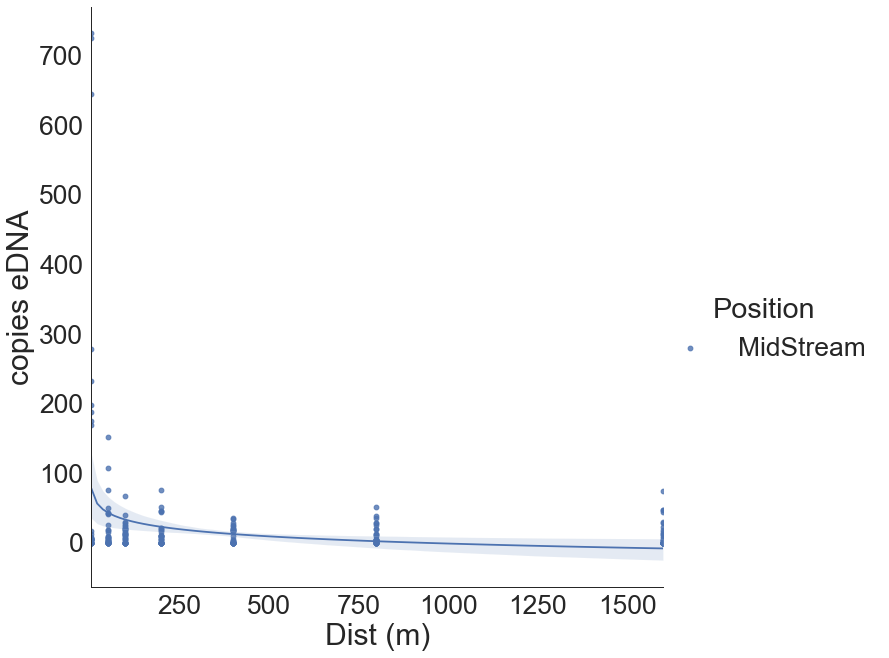

In [115]:
wood['copies eDNA'] = wood['Pg eDNA']
wood['copies eDNA expanded'] = wood['Pg eDNA']*100
#*100#3705846.15
#wood = wood.query('Detect == 1')
sns.lmplot(data =wood, x = 'Dist (m)', y = 'copies eDNA', hue =  'Position', height = 10, logx=True)

In [169]:
import theano.tensor as tt
from IPython.core.display import display, HTML

wood_dist = wood[['Dist (m)']].values
wood_mass = wood[['FishMass (kg)']].values
wood_vel = wood[['Velocity (m/s)']].values
observed_discrete = wood[['Detect']].values
observed_copies = wood[['copies eDNA']].values
observed_copies_max = wood[['copies eDNA expanded']].values

copies_upper_bound = observed_copies.max()*2
copies_upper_bound_max = observed_copies_max.max()*2

In [171]:
copies_upper_bound_max/1e5

1.46282

In [117]:
from pymc3.distributions import Continuous, Normal

from theano.tensor.random.basic import RandomVariable, normal


class ZeroInflatedNormalRV(RandomVariable):
    name = "zero_inflated_normal"
    ndim_supp = 0
    ndims_params = [0, 0, 0]
    dtype = "int64"
    _print_name = ("ZeroInflatedNormal", "\\operatorname{ZeroInflatedNormal}")

    @classmethod
    def rng_fn(cls, rng, pi,mu ,sigma,  size):
        return rng.normal(mu=mu, sigma=sigma, size=size) * (rng.random(size=size) < pi)
    
    
class ZeroInflatedNormal(Continuous):
    rv_op = ZeroInflatedNormalRV
    
    def __init__(self, mu, sigma, pi, *args, **kwargs):
        super(ZeroInflatedNormal, self).__init__(*args, **kwargs)
        self.mu = mu
        self.sigma = sigma
        self.pi = pi = tt.as_tensor_variable(pi)
        self.Normal = pm.Normal.dist(mu, sigma)

    def logp(self, value):
        return tt.switch(value > 0,
                         tt.log(1 - self.pi) + self.Normal.logp(value),
                         tt.log(self.pi))

In [118]:
def log_clip(X):
    return tt.log(tt.clip(X, 1e-10, 1e10))

def log_clipnp(X):
    return np.log(np.clip(X, 1e-10, 1e10))

In [119]:
0.0440/60

0.0007333333333333333

In [120]:
1/(1+np.exp(-(10-5)))

0.9933071490757153

### Continuous eDNA concentration model

Finished [100%]: Average Loss = 1.0123e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
degradation,0.007944,0.000104,0.007753,0.008142,0.000001,0.000001,5162.473655,4818.286551,NaN
diffusion,1.875102,0.055753,1.774295,1.982342,0.000775,0.000548,5175.878087,4922.069274,NaN
eDNA production rate,30057.799908,10.716958,30037.548558,30077.987339,0.150570,0.106475,5059.808379,4299.639445,NaN
sigma,315.921313,0.671529,314.639328,317.158264,0.009649,0.006823,4841.177056,4750.862729,NaN


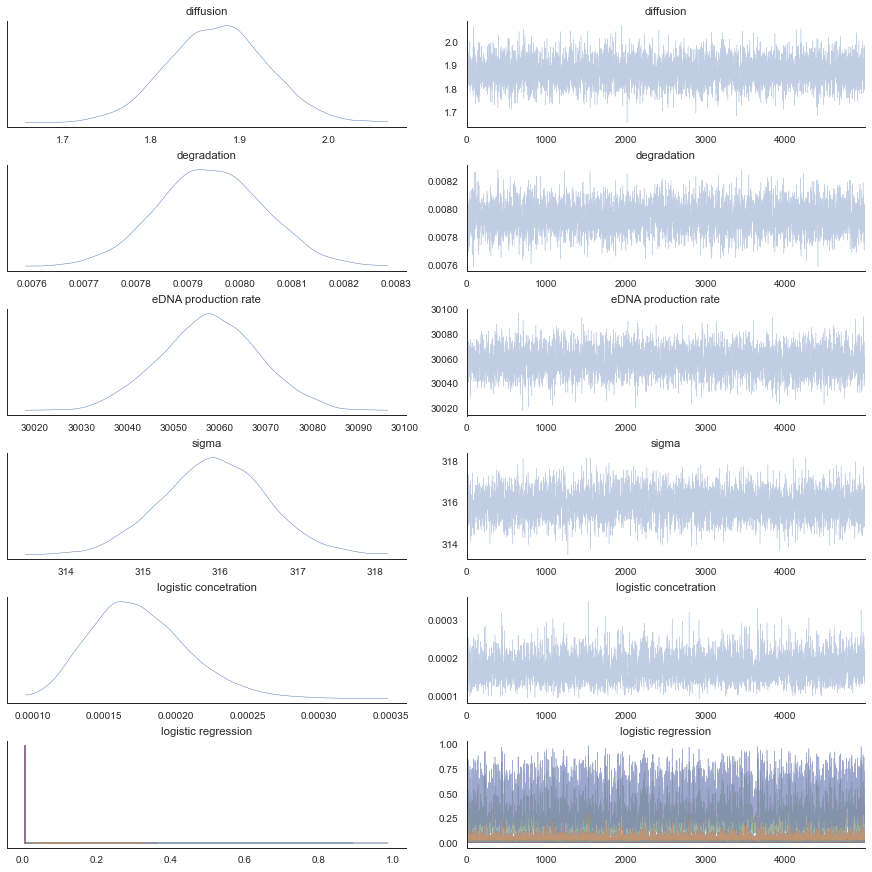

In [158]:
with pm.Model() as continouns_model:
    D = pm.Bound(pm.Normal, lower=1e-2, upper = 10)('diffusion',  mu=.1, sigma = 10. ) #,shape=(wood_vel.shape[0], 1)
    λ = pm.Bound(pm.Normal, lower=7.3e-5, upper = 7.3e-1)('degradation', mu=7.3e-4,sigma = 10.) #,shape=(wood_vel.shape[0], 1)
    u = pm.Bound(pm.Normal, lower=3e2, upper = 3e6)('eDNA production rate', mu= 3e4, sigma=10.0) #shape=(wood_vel.shape[0], 1) #pm.Lognormal
    #Vadj = pm.Bound(pm.Normal, lower=-.1, upper = .2)('River_scaler', mu= 0, sigma=1, shape=(wood_vel.shape[0], 1))

    BV = 1e-5     ### boat velocity
    T = 10*20     ### sampling time
    pf = 5/1000   ### pump flow
    H = 10        ### river cross section area    
    sigma = pm.HalfNormal("sigma", sigma=1)
        
    Yhat = pm.Deterministic('eDNA transport model',sample_eDNA_transect_dowstream_only_tt(wood_dist , T, pf, BV, H, wood_mass, u, D, λ, wood_vel))
    
    Yhat = tt.clip(Yhat, 1e-2, copies_upper_bound_max) #cut large values
    #Yhatlog = log_clip(Yhat)
    
    
    #a = pm.Normal('logistic base', mu= 0, sigma = 1.)
    #c = pm.Bound(pm.Normal, lower=-.1, upper = .1)('logistic distance', mu = 0, sigma=5.0)
    #pi = pm.Deterministic('logistic regression', 1/(1+ tt.exp(-(a+log_clip(Yhat)*b+ wood_dist*c))  )   ) # + tt.log(wood_dist)*c
    #pi = pm.Deterministic('logistic regression', 1/(1+ tt.exp(-tt.clip(a+Yhat*b+ wood_dist*c, -10, 10 ))  )   ) # + tt.log(wood_dist)*c
    # Likelihood (sampling distribution) of observations
    
    ### non zero inflated
    #Y_obs = Normal("Y_obs", mu=Yhat, sigma=sigma,observed=observed_copies_max)
    #Y_obs = Normal("Y_obs", mu=Yhatlog, sigma=sigma, observed=log_clipnp(observed_copies))
    
    ### zero inflated
    b = pm.Bound(pm.Normal, lower=0, upper = 1)('logistic concetration', mu = .5, sigma=5.0)
    pi = pm.Deterministic('logistic regression', 1/(1+ tt.exp(-tt.clip(Yhat*b-5, -5, 30))))

    Y_obs = ZeroInflatedNormal("Y_obs", mu=Yhat, sigma=sigma,pi= pi, observed=observed_copies_max)
    #Y_obs = ZeroInflatedNormal("Y_obs", mu=Yhatlog, sigma=sigma,pi= pi, observed=log_clipnp(observed_copies))
    
    
    fitted = pm.fit(method="fullrank_advi",n=100000) #, start = pm.find_MAP()
    trace = fitted.sample(5000 )# 
    #display(pm.model_to_graphviz(continouns_model))
    #trace = pm.sample(10000, tune=1000, cores=1, return_inferencedata=True, init = 'advi_map')#, init = 'advi_map'
    az.plot_trace(trace,var_names= [ '~eDNA transport model']); #var_names= [ '~eDNA transport model']
    display(az.summary(trace, round_to=8,  var_names= ['degradation', 'diffusion', 'eDNA production rate', 'sigma']))
    #display(az.summary(trace,var_names= [ 'degradation', 'eDNA production rate'] ,round_to=5))
    sns.despine()



    
        

In [162]:
dataframe_vals = az.summary(trace, round_to=8,  var_names= ['degradation', 'diffusion', 'eDNA production rate'])['mean']
dataframe_vals.index = ['λ', 'D', 'u']
dataframe_vals.to_dict()

C:\Users\thiag\anaconda3\envs\mcmc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


{'λ': 0.00794355, 'D': 1.87510179, 'u': 30057.79990847}

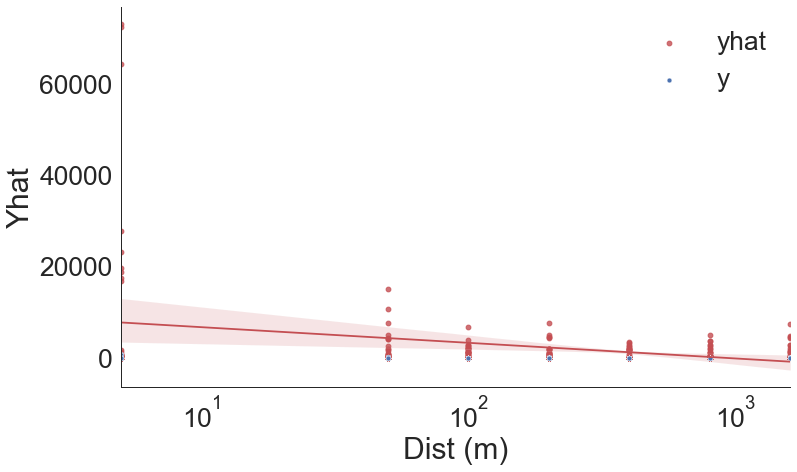

In [163]:
ppc = pm.sample_posterior_predictive(trace, model =continouns_model, var_names=['Y_obs','eDNA transport model'])
wood['Yhat'] = ppc['Y_obs'].mean(axis= 0)
f, ax = plt.subplots(figsize=(12, 7))
ax.set(xscale="log")# , yscale="log"
#sns.scatterplot(data =wood, x = 'Dist (m)', y = 'Yhat', label = 'yhat', s = 100)
sns.regplot(data =wood, x = 'Dist (m)', y = 'Yhat', label = 'yhat' ,marker = 'o',logx = True,color = 'r')

sns.scatterplot(data =wood, x = 'Dist (m)', y = 'copies eDNA', label = 'y')
sns.despine()
#plt.ylim([0,100])
#wood

[None, None]

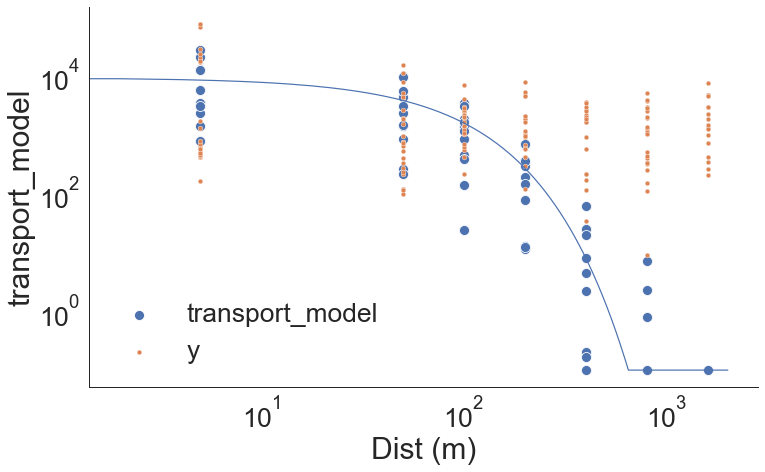

In [164]:
#A[:, np.random.randint(A.shape[0], size=2)] sample from trace
f, ax = plt.subplots(figsize=(12, 7))

#ppc = pm.sample_posterior_predictive(trace, model =continouns_model, var_names=['eDNA transport model'])
wood['transport_model'] = np.clip(ppc['eDNA transport model'].mean(axis= 0), 1e-1, copies_upper_bound*10000)


plt.semilogy( np.linspace(0,2000,1000), np.clip(sample_eDNA_transect_dowstream_only(x0 = np.linspace(0,2000,1000) ,BV = 1e-5,T = 10*20,pf = 5/1000, H = 10, 
                                    B = wood['FishMass (kg)'].mean(), V = wood['Velocity (m/s)'].mean(),**dataframe_vals), 1e-1, 1e10))

sns.scatterplot(data =wood, x = 'Dist (m)', y = 'transport_model', label = 'transport_model', s = 100)

sns.scatterplot(data =wood, x = 'Dist (m)', y = 'copies eDNA expanded', label = 'y')
sns.despine()
#plt.ylim([0.01, 10000])
ax.set(xscale="log", yscale = "log")# , yscale = "log" 


In [165]:
218*1.5

327.0

In [166]:
#wood['estimated diffusion'] = trace['diffusion'].mean(axis= 0)
#wood['estimated degradation'] = trace['degradation'].mean(axis= 0)
#wood['estimated production'] = trace['eDNA production rate'].mean(axis= 0)

#sns.boxenplot(x="River", y='estimated diffusion', data=wood)
#sns.stripplot(x="River", y='estimated diffusion', data=wood, color = 'black')
#sns.despine()
#plt.show()

#sns.boxenplot(x="River", y='estimated degradation', data=wood)
#sns.stripplot(x="River", y='estimated degradation', data=wood, color = 'black')
#sns.despine()
#plt.show()


In [167]:
#sns.pairplot(wood[['estimated diffusion', 'estimated degradation', 'Dist (m)', 'River', 'Velocity (m/s)']], hue="River", height =4 )
#sns.despine()
#plt.show()


C:\Users\thiag\anaconda3\envs\mcmc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


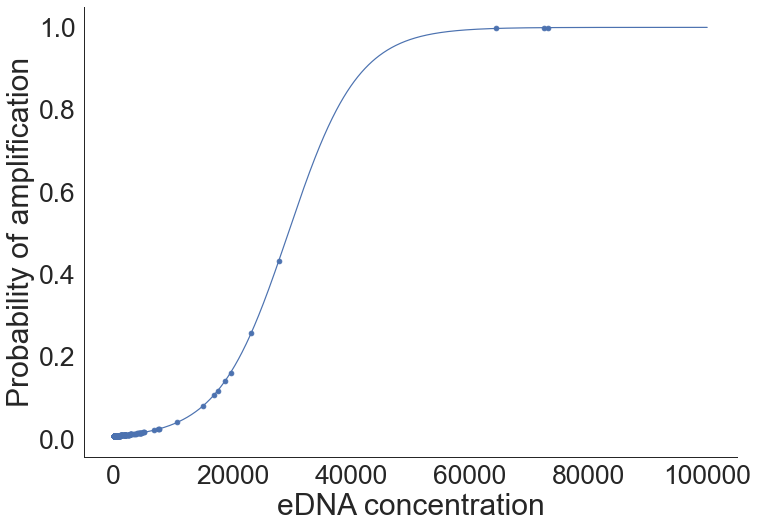

In [168]:
sptmpd = az.summary(trace, round_to=5,  var_names= [ 'logistic concetration'])
sptmpd

def logisreg_concentration(X):
    return 1/(1+np.exp(-(sptmpd.loc['logistic concetration', 'mean']*(X) -5) ))

edna_conc = np.linspace(0, 1e5, 1000)
#p_amp = 1/(1+np.exp(-(sptmpd.loc['logistic base', 'mean'] + sptmpd.loc['logistic concetration', 'mean']*np.log(edna_conc)) ))
p_amp = logisreg_concentration(edna_conc)

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
plt.plot(edna_conc, p_amp)
plt.ylabel('Probability of amplification')
plt.xlabel('eDNA concentration')
sns.despine()

#p_amp = 1/(1+np.exp(-(sptmpd.loc['logistic base', 'mean'] + sptmpd.loc['logistic concetration', 'mean']*np.log(observed_copies) )))

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
plt.scatter(observed_copies_max, logisreg_concentration(observed_copies_max))
plt.ylabel('Probability of amplification')
plt.xlabel('eDNA concentration')
sns.despine()


In [ ]:
sptmpd = az.summary(trace, round_to=5,  var_names= ['logistic base', 'logistic distance'])
sptmpd

edna_conc = np.linspace(0, 2500, 10000)


def logisreg_distance(X):
    return 1/(1+np.exp(-(sptmpd.loc['logistic base', 'mean'] + sptmpd.loc['logistic distance', 'mean']*(X)) ))


#p_amp = 1/(1+np.exp(-(sptmpd.loc['logistic base', 'mean'] + sptmpd.loc['logistic distance', 'mean']*edna_conc) ))
p_amp = logisreg_distance(edna_conc)



sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
plt.plot(edna_conc, p_amp)
plt.ylabel('Probability of amplification')
plt.xlabel('eDNA concentration')
sns.despine()

#p_amp = 1/(1+np.exp(-(sptmpd.loc['logistic base', 'mean'] + sptmpd.loc['logistic distance', 'mean']*wood_dist )))
p_amp = logisreg_distance(wood_dist)


sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
plt.scatter(wood_dist, p_amp)
plt.ylabel('Probability of amplification')
plt.xlabel('distance')
#plt.xlim([0,150])
sns.despine()


In [ ]:
print(sptmpd.loc['logistic base', 'mean'], sptmpd.loc['logistic beta', 'mean'])

def CtoP2: 
    return 1/(1+np.exp(-(-.83+ .00781*edna_conc) ))

# using Discrete model

In [94]:
7.3e-4

0.00073

Finished [100%]: Average Loss = 279.23
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
degradation,0.000133,0.000023,0.000105,0.000173,3.300000e-07,2.300000e-07,4916.734855,4982.915434,NaN
diffusion,0.250511,0.148450,0.023008,0.482322,2.190890e-03,1.549290e-03,4618.507942,4665.615549,NaN
eDNA production rate,300.554005,10.980118,279.791123,320.576704,1.551081e-01,1.096844e-01,4991.291213,4817.642399,NaN


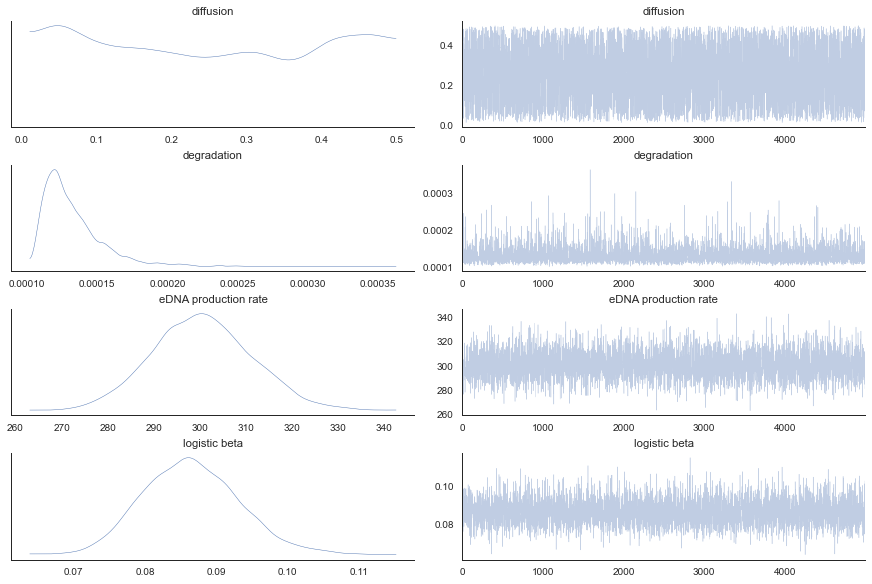

In [135]:
with pm.Model() as discrete:
    
    D = pm.Bound(pm.Normal, lower=1e-2, upper = .5)('diffusion',  mu=.1, sigma = 10. ) #,shape=(wood_vel.shape[0], 1)
    λ = pm.Bound(pm.Normal, lower=1e-4, upper = 7.3e-3)('degradation', mu=7.3e-4,sigma = 10.) #,shape=(wood_vel.shape[0], 1)
    u = pm.Bound(pm.Normal, lower=3e2/100, upper = 3e6/100)('eDNA production rate', mu= 3e4/100, sigma=10.0) #shape=(wood_vel.shape[0], 1) #pm.Lognormal
    #a = pm.Normal('logistic base', mu= 0, sigma = 1.)
    #a = 0
    b = pm.Bound(pm.Normal, lower=0, upper = 1)('logistic beta', mu= 1, sigma=1.0)
    #b = 1e-7
    #copy_number_scaler = pm.Bound(pm.Normal, lower=0.0, upper = 1)('copy number scaler', mu= .1, sigma=1)
    #Vmultiplier = pm.Bound(pm.Normal, lower=-.5, upper = .5)('River_scaler', mu= 0, sigma=1, shape=(wood_vel.shape[0], 1)) #
    #Vest = pm.Bound(pm.Exponential, lower=0.0, upper = 1)('V', lam=.1, shape=(wood_vel.shape[0], 1))
    #D = 1e-3
    #u = 2e5
    BV = 1e-5     ### boat velocity
    T = 10*20     ### sampling time
    pf = 5/1000   ### pump flow
    H = 10        ### river cross section area    
        
    
    q = pm.Deterministic("dispersion model", sample_eDNA_transect_dowstream_only_tt(wood_dist , T, pf, BV, H, wood_mass, u, D, λ, wood_vel))
    #r = pm.Deterministic('log conversion and scaling',tt.log(q)*b)
    s = pm.Deterministic('logistic regression', 1/(1+ tt.exp(-tt.clip(q*b-5, -20, 20)))) ## logistic fit


    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli("Y_obs", p = s,observed=observed_discrete)
    
    
    
    fitted = pm.fit(method="fullrank_advi",n=100000) #, start = pm.find_MAP()
    trace = fitted.sample(5000)# 
    #display(pm.model_to_graphviz(continouns_model))
    #trace = pm.sample(10000, tune=1000, cores=1, return_inferencedata=True, init = 'advi_map')#, init = 'advi_map'
    az.plot_trace(trace, var_names= [ '~logistic regression', "~dispersion model"]); #
    display(az.summary(trace, round_to=8,  var_names= ['degradation', 'diffusion', 'eDNA production rate']))
    #display(az.summary(trace,var_names= [ 'degradation', 'eDNA production rate'] ,round_to=5))
    sns.despine()

    
    
    
        

In [137]:
dataframe_vals = az.summary(trace, round_to=8,  var_names= ['degradation', 'diffusion', 'eDNA production rate'])['mean']
dataframe_vals.index = ['λ', 'D', 'u']
dataframe_vals.to_dict()

C:\Users\thiag\anaconda3\envs\mcmc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


{'λ': 0.00013292, 'D': 0.25051092, 'u': 300.5540054}

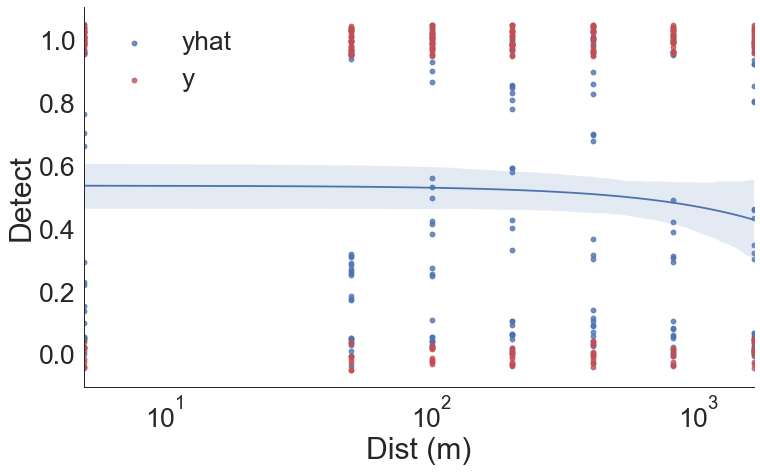

In [138]:
ppc = pm.sample_posterior_predictive(trace, model =discrete, var_names=['Y_obs'])
wood['Yhat'] = ppc['Y_obs'].mean(axis= 0)
f, ax = plt.subplots(figsize=(12, 7))
ax.set(xscale="log")# , yscale="log"

sns.regplot(data =wood, x = 'Dist (m)', y = 'Yhat', label = 'yhat',  y_jitter = .05, logistic = True, marker = 'o')
sns.regplot(data =wood, x = 'Dist (m)', y = 'Detect', label = 'y', color = 'r', y_jitter = 0.05, fit_reg = False, )

sns.despine()
plt.legend(loc = 'best')
#plt.ylim([0,100])
#wood

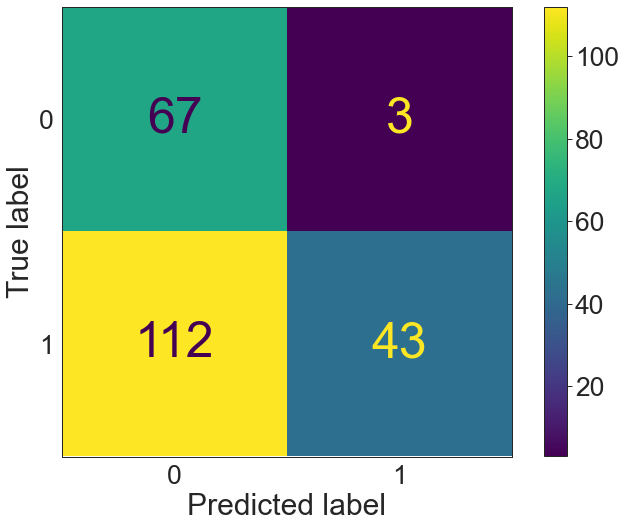

In [139]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(wood['Detect'].astype(int), wood['Yhat'].astype(int))).plot()

[None, None]

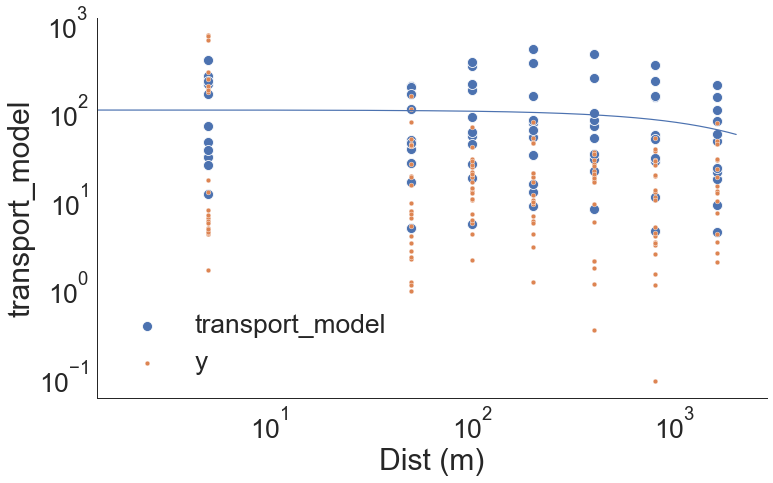

In [140]:
#A[:, np.random.randint(A.shape[0], size=2)] sample from trace
f, ax = plt.subplots(figsize=(12, 7))

ppc = pm.sample_posterior_predictive(trace, model =discrete, var_names=['dispersion model'])
wood['transport_model'] = np.clip(ppc['dispersion model'].mean(axis= 0), 1e-2, copies_upper_bound*10000)
#wood['transport_model'] = ppc['eDNA transport model'].mean(axis= 0)
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'transport_model', label = 'transport_model', s = 100)

plt.plot( np.linspace(0,2000,1000), np.clip(sample_eDNA_transect_dowstream_only(x0 = np.linspace(0,2000,1000) ,BV = 1e-5,T = 10*20,pf = 5/1000, H = 10, 
                                    B = wood['FishMass (kg)'].mean(), V = wood['Velocity (m/s)'].mean(),**dataframe_vals), 1e-2, 1e10))

sns.scatterplot(data =wood, x = 'Dist (m)', y = 'copies eDNA', label = 'y')
sns.despine()
ax.set(xscale="log", yscale = "log")# , yscale = "log" 


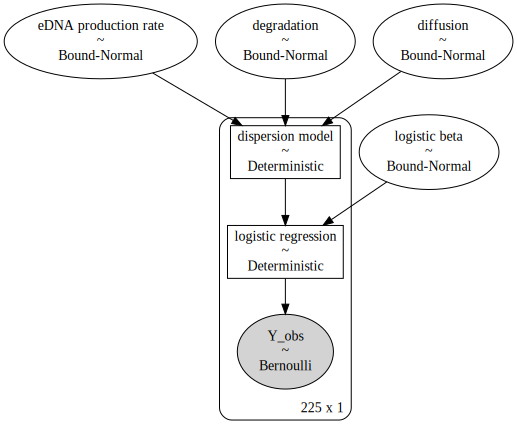

In [101]:
pm.model_to_graphviz(discrete)

# Using scipy to optimize

In [ ]:
from scipy.optimize import minimize
from scipy.stats import trimboth
def to_minimize(list_of_param):
    dif, deg, prod = list_of_param
    data =  trimboth(np.sort(sample_eDNA_transect_dowstream_only(wood_dist , T, pf, BV, 10, wood_mass, prod, dif, deg,  wood_vel) - observed_copies), .1)
    return abs(data).sum()
    
diff, degra, production = minimize(to_minimize, [1e-3, 2e-3, 1e7], bounds = [(1e-3,1), (1e-3, 1), (1e4, 1e7)]).x
wood['yhat_scipy'] = sample_eDNA_transect_dowstream_only(wood_dist , T, pf, 1e-5, 10, wood_mass, production, diff, degra, wood_vel)
f, ax = plt.subplots(figsize=(12, 7))
ax.set(xscale="log", yscale="log") #,
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'Yhat', label = 'yhat')
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'copies eDNA', label = 'y') 
sns.scatterplot(data =wood, x = 'Dist (m)', y = 'yhat_scipy', label = 'yhat_scipy') #plt.ylim([0,100])
sns.despine()

In [ ]:
#probfunction = pd.DataFrame([[-2,.333],[-1, .875],[0,1],[1,1], [-10,0], [-3,0], [0, 1]], columns=['initial eDNA', 'probability of amplification'])
#probfunction['copy number'] = probfunction['initial eDNA'].apply(lambda x: 10**x * 3.65*1e6)
#model2 = sm.Logit(probfunction['probability of amplification'].values, probfunction['copy number'].values)
#result2 = model2.fit()
#def CtoP(x): return (result2.predict(x)-.5)/.5


In [ ]:
 wood_comp[['Detect']].values

In [ ]:
tt.switch()